# FP-growth
FP-growth 算法能更有效地挖掘频繁项集。于Apriori算法构建,但是数据结构不同，使用叫做 FP树 的数据结构结构来存储集合。

## 1. 构建 FP-tree
FP-tree 是一个紧凑的树状数据结构，用于表示事务数据集中的频繁项。构建过程如下：

1. **扫描事务数据集一次**：
   - 统计每个项（item）的支持度（support），丢弃低于最小支持度阈值的项。
   - 对剩下的项按照支持度从高到低排序，形成频繁项的顺序。

2. **第二次扫描事务数据集**：
   - 根据频繁项的顺序，将每个事务插入 FP-tree 中。相同前缀的事务会共享树中的相同路径，从而压缩存储空间。
   - 每个节点记录对应项和计数值。
   - 使用一个链表（header table，头表）将树中相同项连接起来，便于后续的模式挖掘。

---

## 2. 挖掘频繁项集
通过递归地从 FP-tree 中提取频繁项集，不需要生成候选项集：

1. **从头表开始**：
   - 按照头表中的项，从频率最低的项开始，依次生成该项的条件模式基（conditional pattern base），即以该项为条件的所有前缀路径的集合。

2. **构建条件 FP-tree**：
   - 从条件模式基中构建一个新的 FP-tree，表示以该项为条件的事务结构。
   - 如果条件 FP-tree 不为空，递归挖掘该树，继续生成更长的频繁项集。

3. **合并结果**：
   - 将递归过程中生成的频繁项集合并，得到完整的频繁项集。

## 流程

### 步骤1:
-   遍历所有的数据集合，计算所有项的支持度。
-   丢弃非频繁的项。
-   基于 支持度 降序排序所有的项。
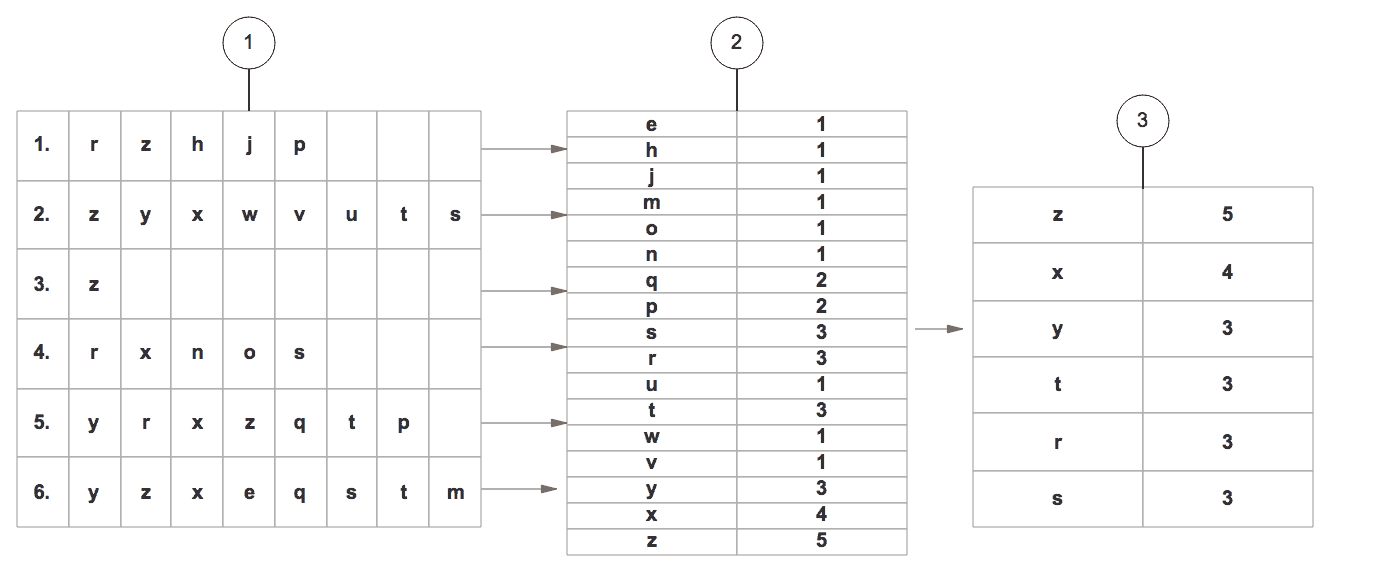
-   所有数据集合按照得到的顺序重新整理。
-   重新整理完成后，丢弃每个集合末尾非频繁的项。
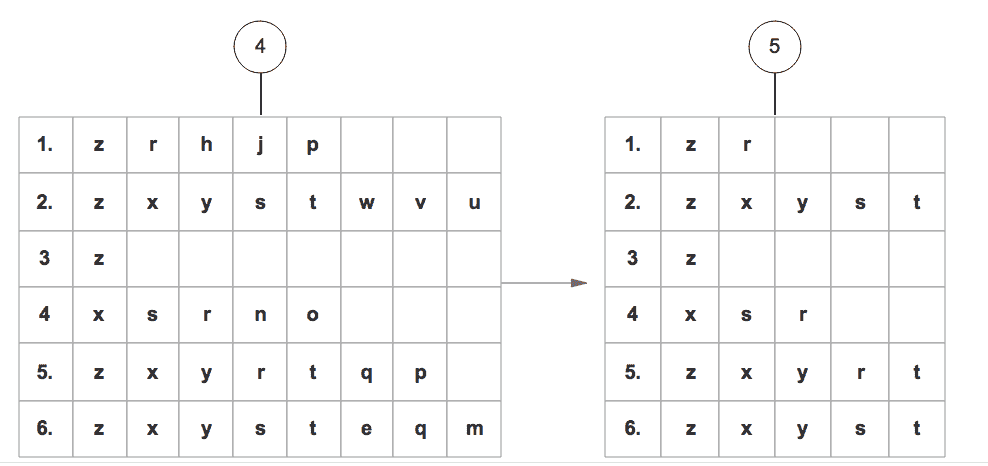

### 步骤2
-   读取每个集合插入FP树中，同时用一个头部链表数据结构维护不同集合的相同项。
-   相同前缀共享相同空间
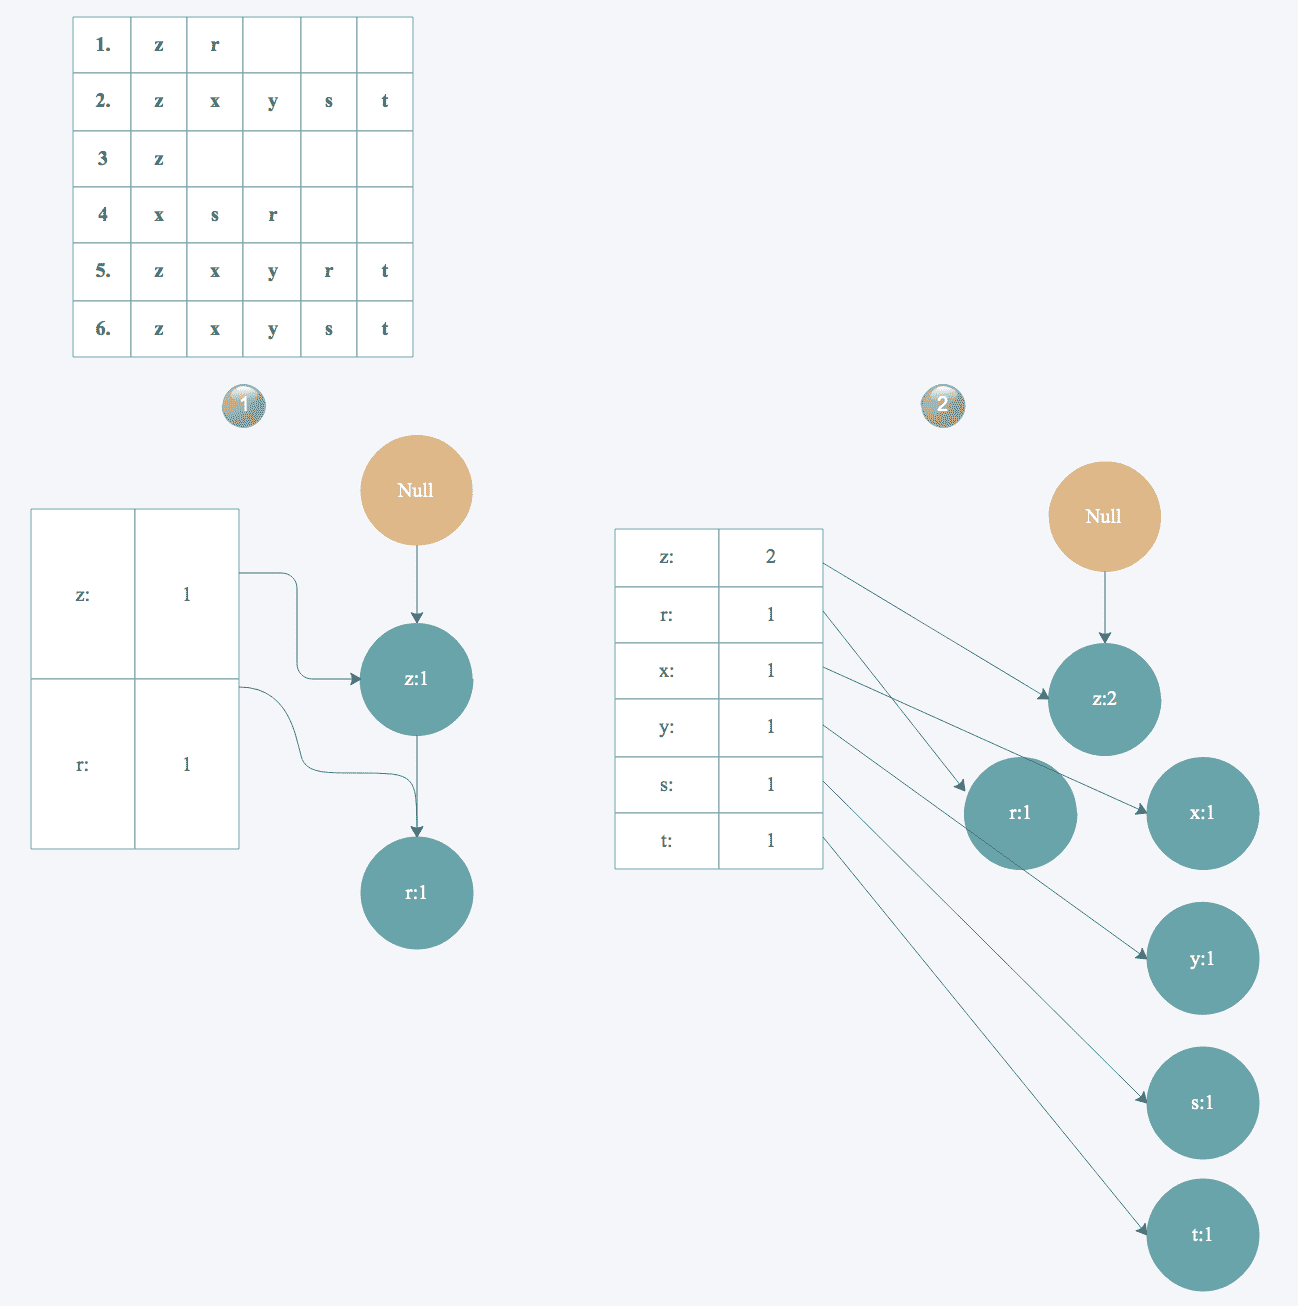
-  最终得到下面这样一棵FP树
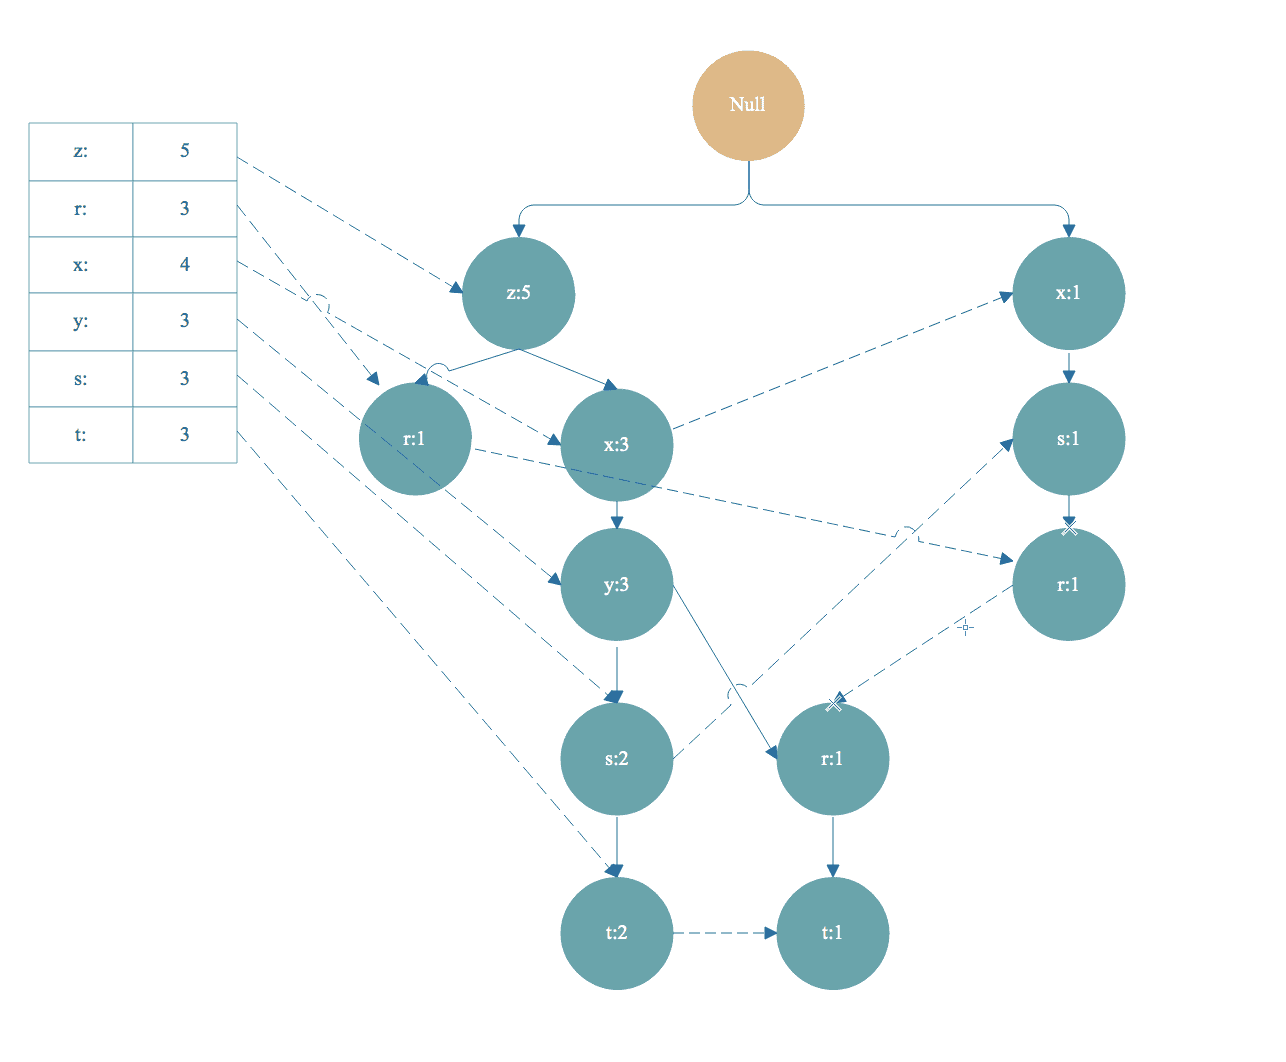

### 步骤3
-  对头部链表进行降序排序
-  对头部链表节点从小到大遍历，得到条件模式基，同时获得一个频繁项集。
-  如上图，从头部链表 t 节点开始遍历，t 节点加入到频繁项集。找到以 t 节点为结尾的路径如下:
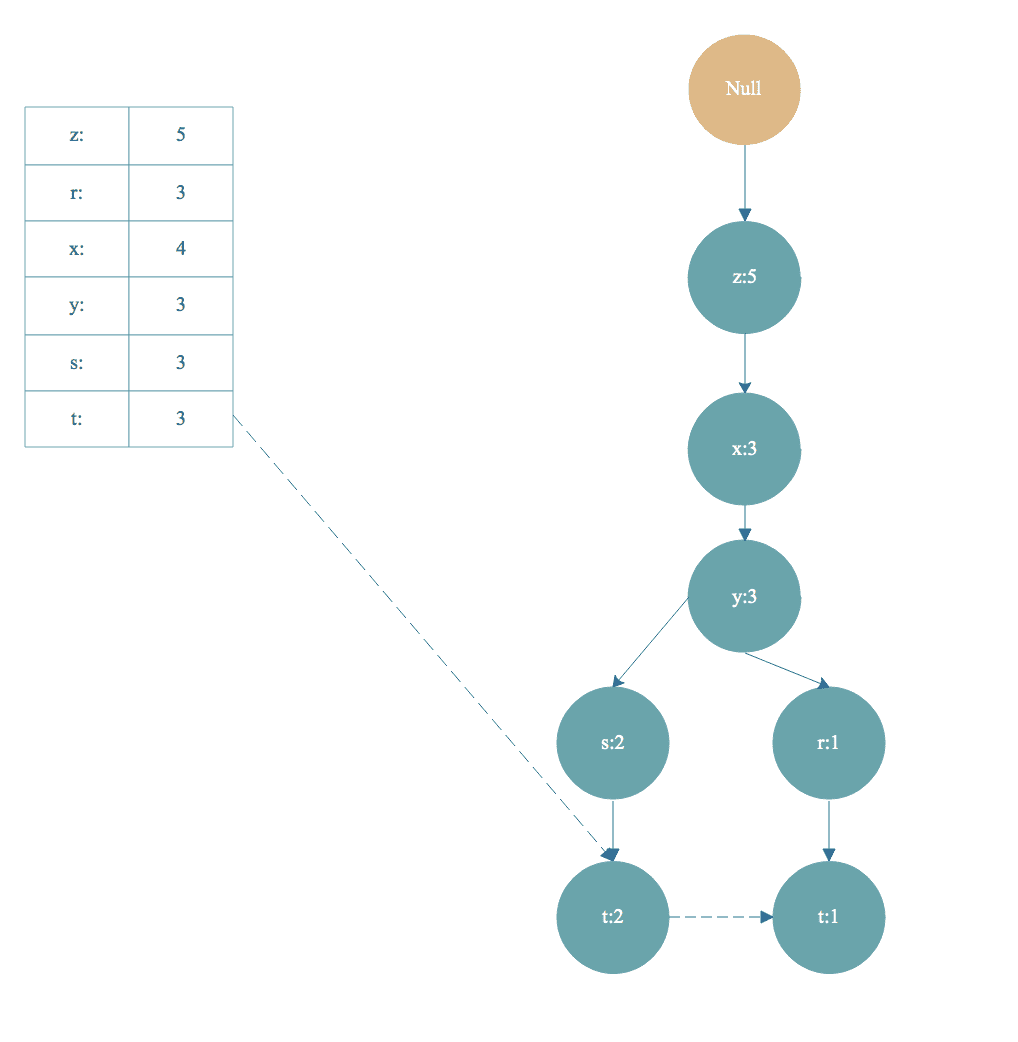
-  去掉FP树中的t节点，得到条件模式基<路径, 值>[z,x,y,s,t]:2，[z,x,y,r,t]:1 。
   -  此时相当于有3条数据，分别为 [z,x,y,s],[z,x,y,s] 和 [z,x,y,r]，通过同样的方法构建新的FP树
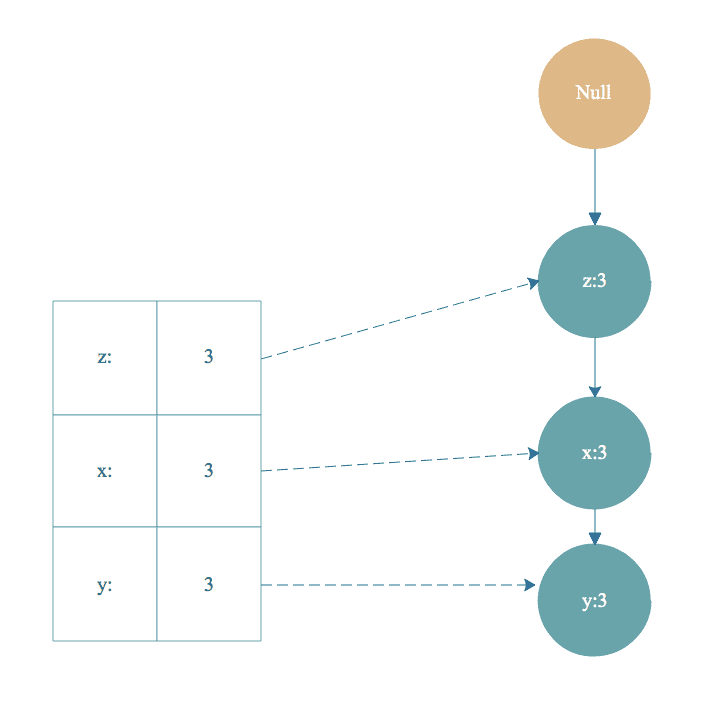
-  根据 t-条件FP树 的头部链表进行遍历，从 y 开始。得到频繁项集 ty 。然后又得到 y 的条件模式基，构造出 ty的条件FP树，即 ty-条件FP树。继续遍历ty-条件FP树的头部链表，得到频繁项集 tyx，然后又得到频繁项集 tyxz. 然后得到构造tyxz-条件FP树的头部链表是空的，终止遍历。我们得到的频繁项集有 t->ty->tyx->tyxz，这只是一小部分。

In [2]:
from collections import defaultdict

class FPNode:
    """
    A node in the FP tree.
    """
    def __init__(self, item, count=0, parent=None):
        self.item = item  # 节点表示的项
        self.count = count  # 节点的计数值
        self.parent = parent  # 父节点
        self.children = {}  # 子节点字典
        self.link = None  # 链接到下一个相同项的节点

class FPTree:
    def __init__(self):
        self.root = FPNode(None) # 根节点
        self.headerTable = defaultdict(list) # 头表，用于存储每个项的链表

    def insert(self, transaction):
        """
        将一条事务插入 FP-tree。
        :param transaction: 按支持度排序后的事务
        """
        current = self.root
        for item in transaction:
            # 如果当前项不是当前节点的子节点，则创建一个新的子节点
            if item not in current.children:
                current.children[item] = FPNode(item, parent=current)
                # 更新头表
                self.headerTable[item].append(current.children[item])
            # 进入子节点
            current = current.children[item]
            current.count += 1

def construct_fp_tree(transactions, minSupport):
    """
    构建 FP-tree。
    :param transactions: 原始事务数据集
    :param minSupport: 最小支持度阈值
    :return: 构建完成的 FP-tree
    """
    # 统计每个项的支持度
    itemSupport = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            itemSupport[item] += 1

    # 过滤掉不满足最小支持度的项
    itemSupport = {k: v for k, v in itemSupport.items() if v >= minSupport}

    # 按支持度降序排序
    sortedItems = sorted(itemSupport.keys(), key=itemSupport.get, reverse=True)

    # 构建 FP-tree
    tree = FPTree()
    for transaction in transactions:
        # 按频繁项顺序重新排序事务
        sortedTransaction = [item for item in transaction if item in itemSupport]
        sortedTransaction.sort(key=lambda x: itemSupport[x], reverse=True)
        # 插入事务
        tree.insert(sortedTransaction)

    return tree, itemSupport

def mine_fp_tree(tree, headerTable, minSupport):
    """
    从 FP-tree 中挖掘频繁项集。
    :param tree: 构建好的 FP-tree
    :param headerTable: FP-tree 的头表
    :param minSupport: 最小支持度阈值
    :return: 所有频繁项集
    """
    def mine_subtree(item, nodes):
        """
        挖掘以某项为条件的子树。
        :param item: 条件项
        :param nodes: 该项的所有节点
        :return: 条件 FP-tree
        """
        # 构建条件模式基（路径和计数值）
        conditionalBase = []
        for node in nodes:
            path = []
            current = node.parent
            while current and current.item:
                path.append(current.item)
                current = current.parent
            for _ in range(node.count):
                conditionalBase.append(path)

        # 构建条件 FP-tree
        conditionalTree = FPTree()
        for path in conditionalBase:
            conditionalTree.insert(path)
        
        return conditionalTree
    
    # 递归挖掘 FP-tree
    def recursive_mine(tree, suffix):
        for item, nodes in list(tree.headerTable.items()):
            # 后缀模式增加当前项
            newSuffix = suffix + [item]
            yield newSuffix
            # 构建条件 FP-tree
            conditionalTree = mine_subtree(item, nodes)
            if conditionalTree.headerTable:
                yield from recursive_mine(conditionalTree, newSuffix)

    return list(recursive_mine(tree, []))

if __name__ == "__main__":
    # 事务数据集
    transactions = [
        ['A', 'B', 'D', 'E'],
        ['B', 'C', 'E'],
        ['A', 'B', 'D', 'E'],
        ['A', 'B', 'C', 'E'],
        ['A', 'B', 'C', 'E'],
        ['A', 'B', 'D', 'E'],
        ['A', 'B', 'C', 'E'],
        ['A', 'B', 'C', 'E'],
        ['A', 'B', 'C', 'E'],
        ['A', 'B', 'C', 'E']
    ]

    # 最小支持度阈值
    minSupport = 3

    # 构建 FP-tree
    tree, headerTable = construct_fp_tree(transactions, minSupport)

    # 挖掘频繁项集
    frequentItemsets = mine_fp_tree(tree, headerTable, minSupport)

    print("Frequent itemsets:")
    for itemset in frequentItemsets:
        print(itemset)

Frequent itemsets:
['B']
['E']
['E', 'B']
['A']
['A', 'E']
['A', 'B']
['A', 'B', 'E']
['D']
['D', 'A']
['D', 'E']
['D', 'E', 'A']
['D', 'B']
['D', 'B', 'E']
['D', 'B', 'A']
['D', 'B', 'A', 'E']
['C']
['C', 'E']
['C', 'E', 'A']
['C', 'B']
['C', 'B', 'E']
['C', 'B', 'A']
['C', 'B', 'A', 'E']
['C', 'A']
